In [1]:
"""%load_ext pycodestyle_magic
%pycodestyle_on"""

'%load_ext pycodestyle_magic\n%pycodestyle_on'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from function_utils import display_circles
import gc

In [3]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

In [4]:
df = pd.read_csv("datasets/data_segmentation_rfm.csv")
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1,2,2,122
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1,2,4,124
0000f46a3911fa3c0805444483337064,586,1,86.22,4,2,3,423


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        96095 non-null  int64  
 1   Frequency      96095 non-null  int64  
 2   MonetaryValue  96095 non-null  float64
 3   r_quartile     96095 non-null  int64  
 4   f_bins         96095 non-null  int64  
 5   m_quartile     96095 non-null  int64  
 6   RFM_Score      96095 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 5.9+ MB


# Préparation des données

In [6]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] =np.log1p(df["MonetaryValue"])
customers.tail()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,0.693147,7.634540
fffea47cd6d3cc0a88bd621562a9d061,5.743003,0.693147,4.449452
ffff371b4d645b6ecea244b27531430a,6.428105,0.693147,4.731450
ffff5962728ec6157033ef9805bacc48,5.135798,0.693147,4.902976
ffffd2657e2aad2907e67c3e9daecbeb,6.280396,0.693147,4.284414


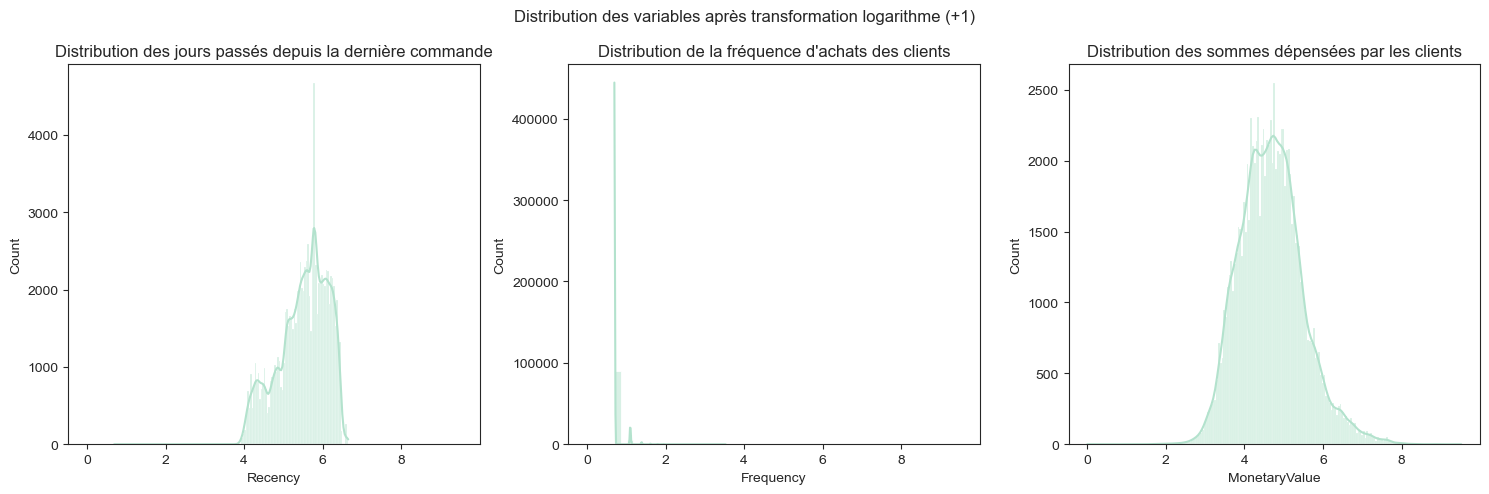

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0], x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show()

- Standardisation

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [ 0.  0. -0.]
Standard Deviation: [1. 1. 1.]


# Réduction de dimensions

In [9]:
from sklearn.decomposition import PCA

n_comp = 2
pca = PCA(n_components=n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

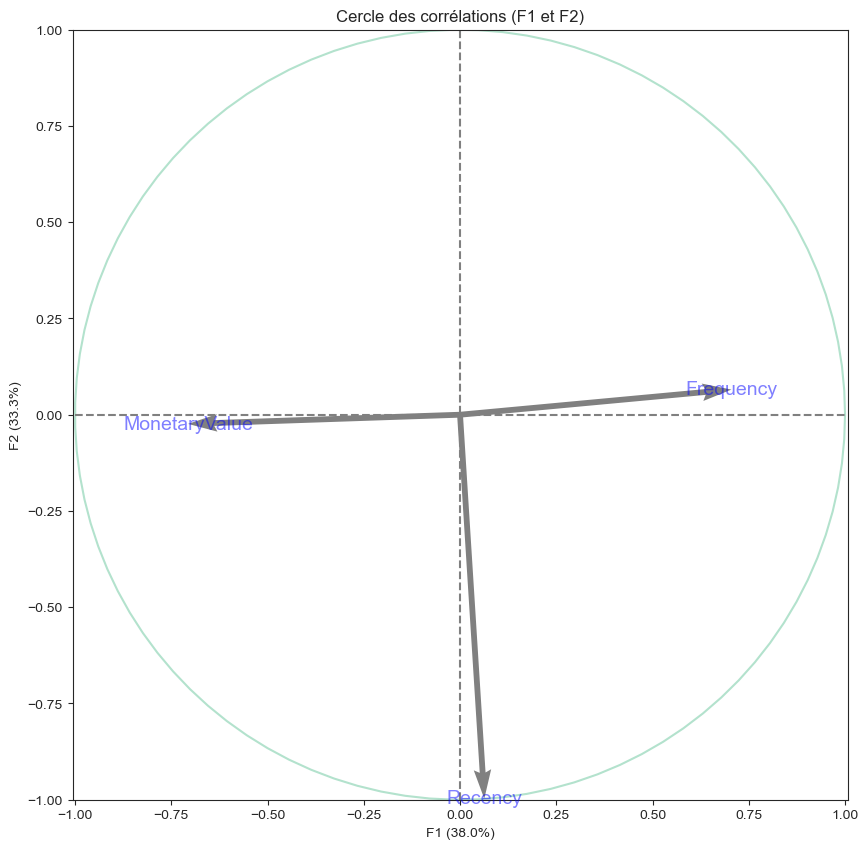

In [10]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

# Modélisation

## K-Means

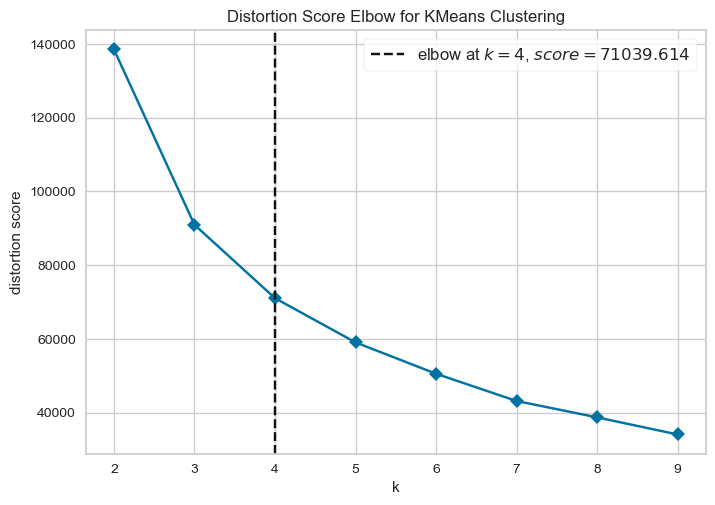

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# Elbow method pour déterminer le nombre de clusters optimale
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show()

In [12]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

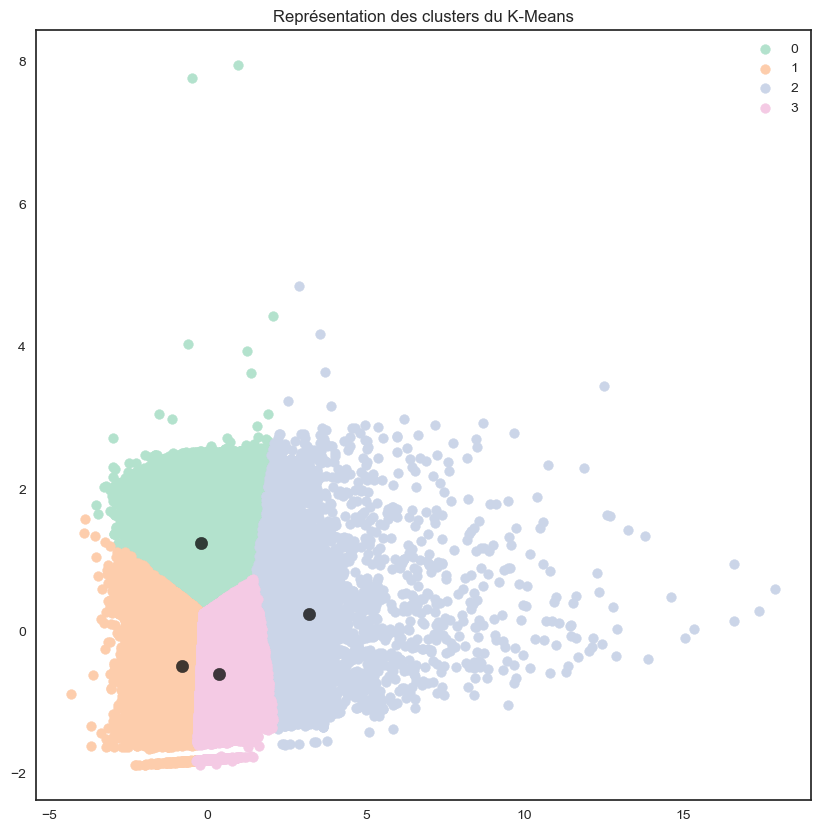

In [13]:
# Calcul du K-Means et affectation du cluster à chaque bâtiment
km = KMeans(n_clusters=4, random_state=42)

# Prédiction
label = km.fit_predict(data_pca)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_pca[label==i, 0] , data_pca[label==i, 1] , label=i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
#plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show()

### Description des clusters obtenus avec le modèle

In [14]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,119.30,1.01,143.40
1,342.33,1.00,302.01
2,289.72,2.44,70.48
3,375.94,1.02,72.73


In [15]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars = ["Recency", "Frequency", "MonetaryValue"],
                      var_name = "Attribute",
                      value_name = "Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,0,Recency,-0.671915
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,Recency,-0.642163
2,0000f46a3911fa3c0805444483337064,3,Recency,1.415528
3,0000f6ccb0745a6a4b88665a16c9f078,3,Recency,0.671591
4,0004aac84e0df4da2b147fca70cf8255,1,Recency,0.520547


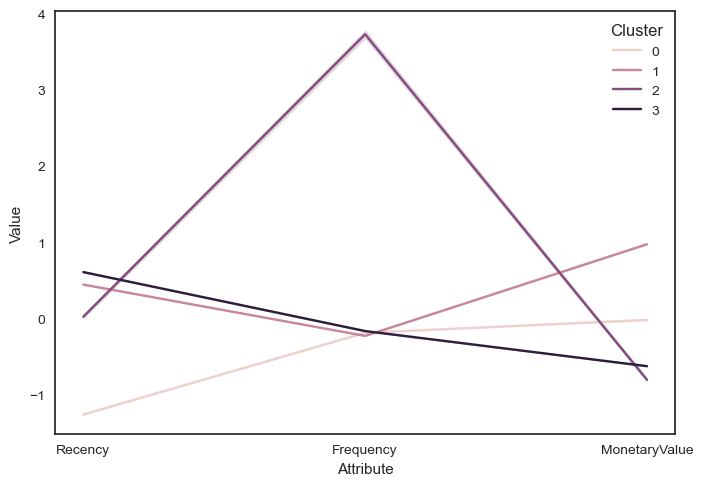

In [16]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

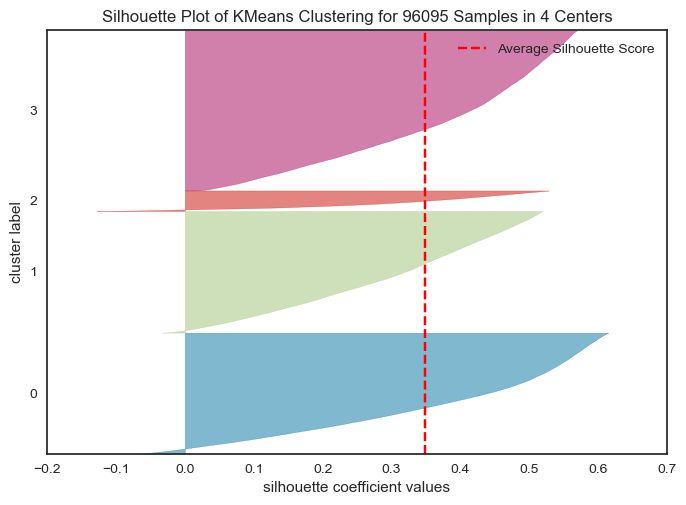

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.34890412075575816
Score de Davies-Bouldin: 0.9189699181451997


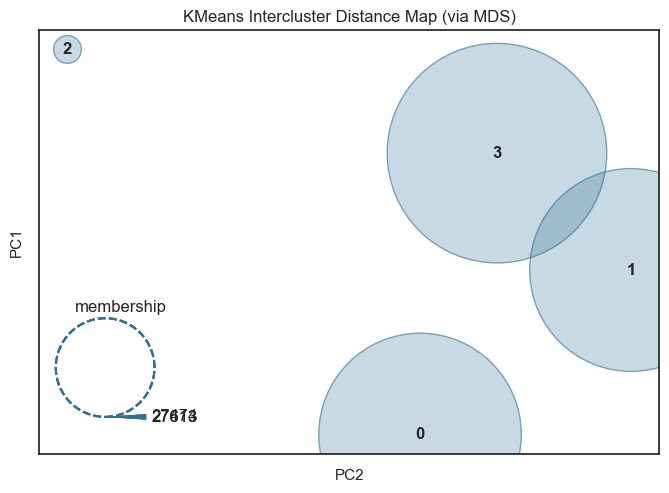

In [19]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), data_pca);

In [20]:
del data_pca
del df
del customers
del df_normalized
del df_nor_melt

In [21]:
gc.collect()

4561

## K-Means (2)

In [22]:
data = pd.read_csv("datasets/data_clustering_complete.csv")
data.set_index("customer_unique_id", inplace=True)
data.head()

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,1,2,2,122,109.119060,bed_bath_table,6.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,1,2,4,124,22.813939,health_beauty,2.0,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,4,2,3,423,516.989962,stationery,25.0,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,3,2,4,324,2479.718229,telephony,20.0,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,3,2,1,321,153.807837,telephony,13.0,5


In [23]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(data['Recency'])
customers["Frequency"] = np.log1p(data["Frequency"])
customers["MonetaryValue"] =np.log1p(data["MonetaryValue"])
customers["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
customers["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
customers.tail()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,0.693147,7.634540,3.332205,7.599119
fffea47cd6d3cc0a88bd621562a9d061,5.743003,0.693147,4.449452,3.433987,7.329999
ffff371b4d645b6ecea244b27531430a,6.428105,0.693147,4.731450,2.708050,7.330095
ffff5962728ec6157033ef9805bacc48,5.135798,0.693147,4.902976,2.484907,6.459433
ffffd2657e2aad2907e67c3e9daecbeb,6.280396,0.693147,4.284414,1.945910,5.876906


In [24]:
scaler = StandardScaler()
customers_normalized = scaler.fit_transform(customers)

In [25]:
n_comp = 2
pca = PCA(n_components=n_comp)
customers_transform = pca.fit_transform(customers_normalized)
features = customers.columns
pcs = pca.components_

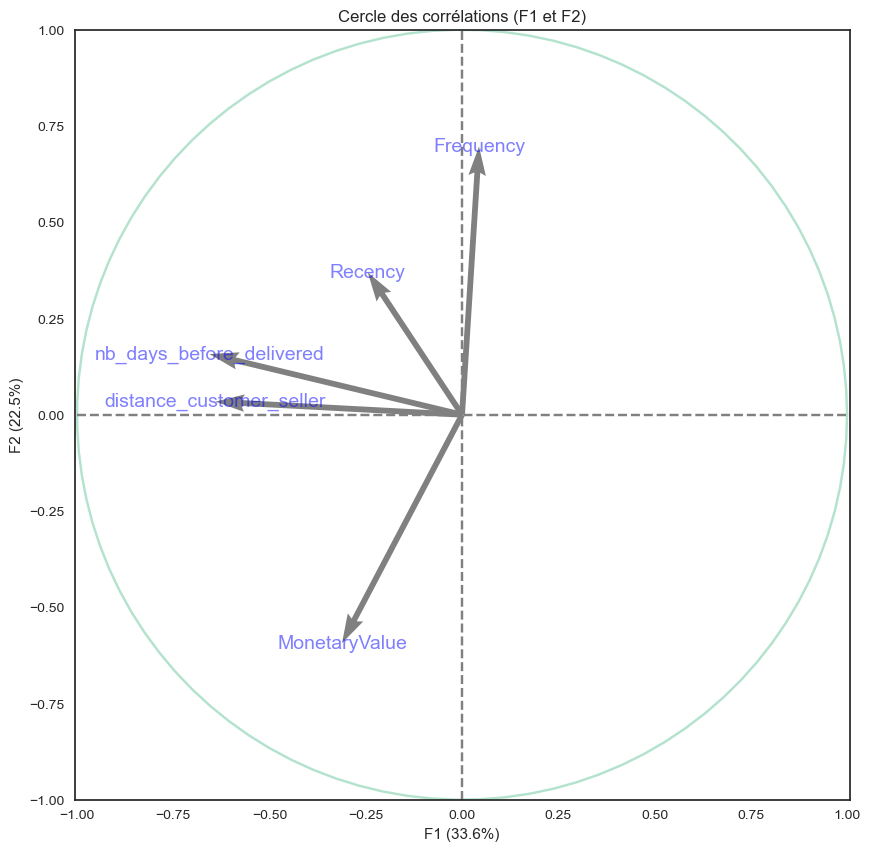

In [26]:
display_circles(pcs, n_comp, pca, [(0,1)], labels=np.array(features))

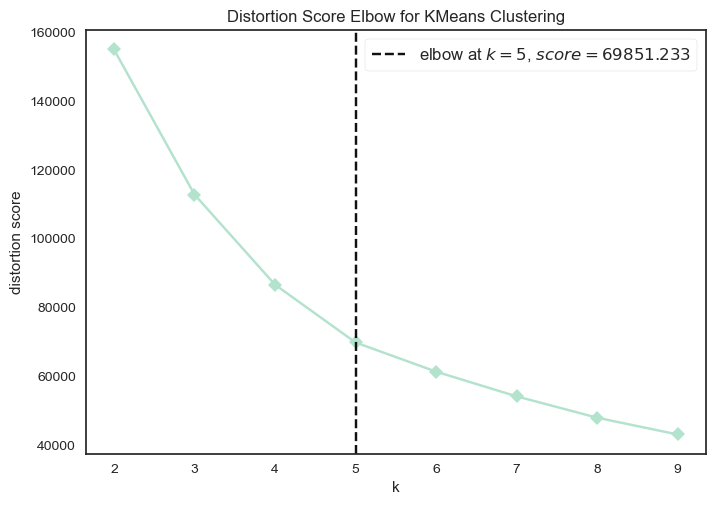

In [27]:
# Elbow method pour déterminer le nombre de clusters optimale

model = KMeans()
visualizer = KElbowVisualizer(model, k =(2, 10), timings=False)
visualizer.fit(customers_transform)
visualizer.show();

In [28]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

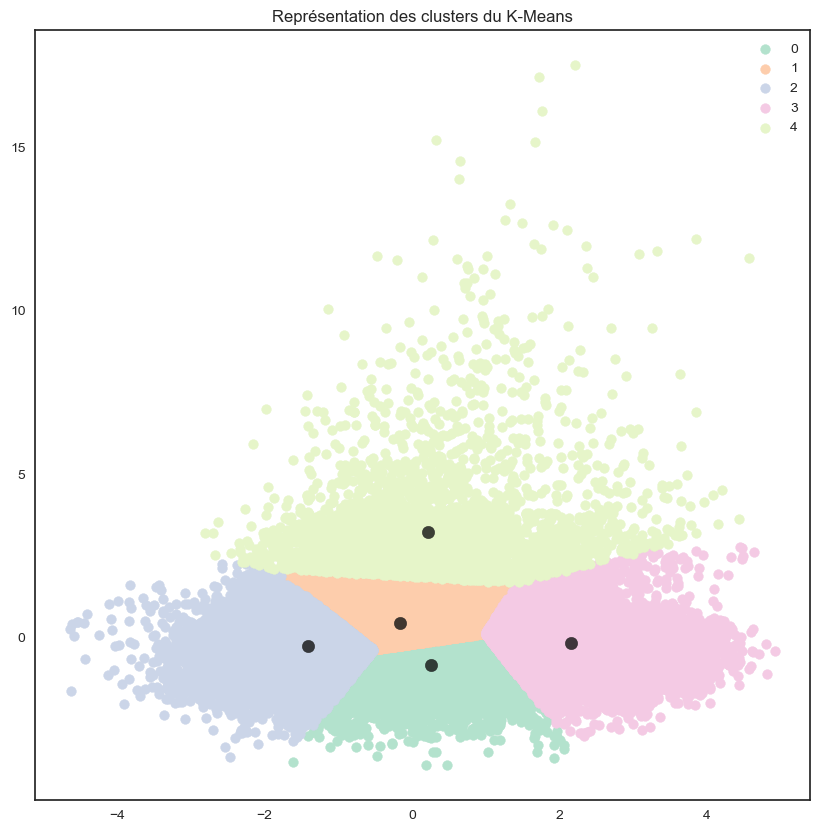

In [29]:
# Calcul du K-Means et affectation du cluster à chaque bâtiment
model = KMeans(n_clusters=5, random_state=42)

#Prédiction
label = model.fit_predict(customers_transform)
 
centroids = model.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:
plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(customers_transform[label == i , 0] ,customers_transform[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
#plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show();

In [30]:
data["Cluster"] = model.labels_
data_clusters_analysis = data.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'nb_days_before_delivered' : "mean",
    "distance_customer_seller" : "mean",
    "product_category_name" : lambda x : x.value_counts().index[0],
    "customer_city" : lambda x : x.value_counts().index[0],
    "review_score" : "mean"}).round(2)

In [31]:
df_normalized = pd.DataFrame(customers_normalized, columns=["Recency", "Frequency",'MonetaryValue', 
                                                            "nb_days_before_delivered", "distance_customer_seller"])
df_normalized['ID'] = data.index
df_normalized["Cluster"] = model.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars = ["Recency", "Frequency", "MonetaryValue",
                                   "nb_days_before_delivered", "distance_customer_seller"],
                      var_name = "Attribute",
                      value_name = "Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,0,Recency,-0.667492
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3,Recency,-0.637610
2,0000f46a3911fa3c0805444483337064,2,Recency,1.429104
3,0000f6ccb0745a6a4b88665a16c9f078,2,Recency,0.681905
4,0004aac84e0df4da2b147fca70cf8255,0,Recency,0.530199


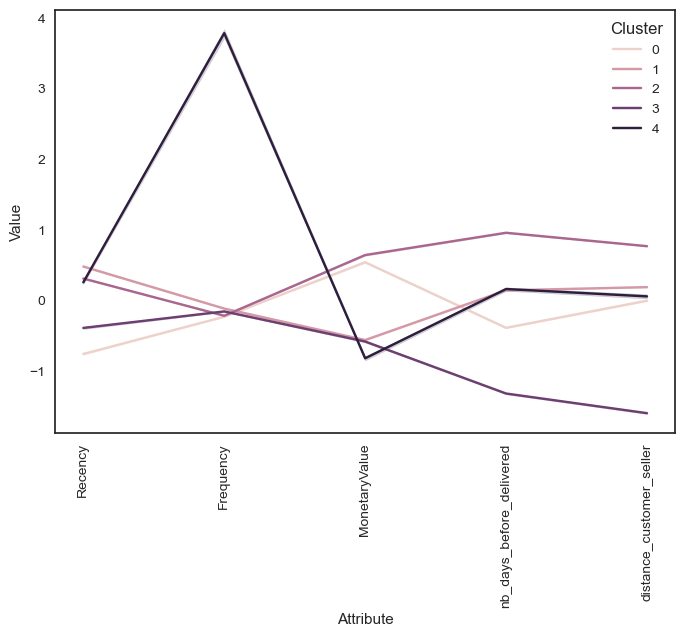

In [32]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.show()

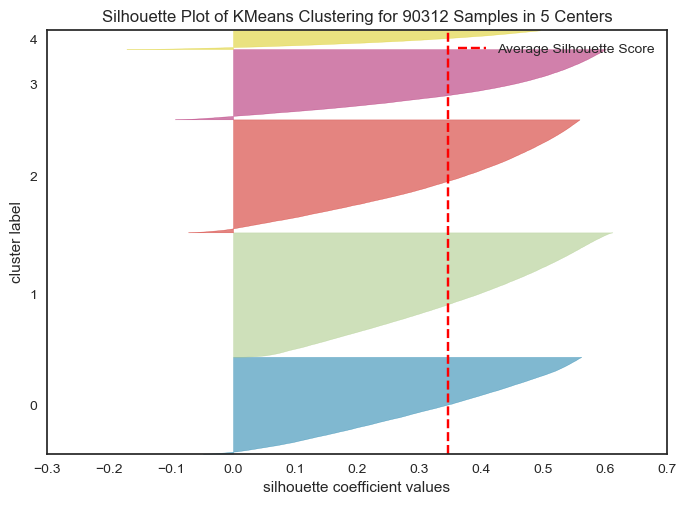

In [33]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(customers_transform)        # Fit the data to the visualizer
visualizer.show();              # Finalize and render the figure

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(customers_transform, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers_transform, label))

Silhouette Score: 0.3466347168500453
Score de Davies-Bouldin: 0.8662105856435979


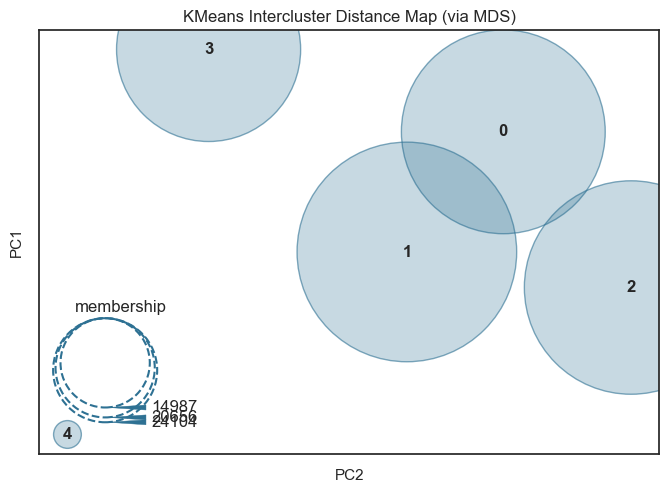

In [35]:
intercluster_distance(KMeans(5, random_state=42), customers_transform);

## Stabilité du clustering

In [36]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] =  np.log1p(data["distance_customer_seller"])

In [37]:
data_test_180d = data_stability.loc[data["Recency"] < 180]

In [38]:
customers_stability = customers.drop(index=data_test_180d.index)
customers_stability["Recency"] = customers_stability["Recency"].values - np.log1p(180)

In [39]:
customers_stability.head()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1.176528,0.693147,4.468434,3.258097,6.249956
0000f6ccb0745a6a4b88665a16c9f078,0.717705,0.693147,3.798182,3.044522,7.816303
0004aac84e0df4da2b147fca70cf8255,0.624549,0.693147,5.287711,2.639057,5.042185
0004bd2a26a76fe21f786e4fbd80607f,0.079618,0.693147,5.123845,0.693147,3.363315
00050ab1314c0e55a6ca13cf7181fecf,0.005510,0.693147,3.594019,1.098612,4.635676


In [40]:
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label1 = model.predict(customers_test_stab)

In [41]:
stability = pd.DataFrame({"label_begin" : label1}, index=customers_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0000f46a3911fa3c0805444483337064,0
0000f6ccb0745a6a4b88665a16c9f078,0
0004aac84e0df4da2b147fca70cf8255,0


In [42]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)

In [43]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label2 = model.predict(customers_test_stab)
stability["label_30d"] = label2

In [44]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label3 = model.predict(customers_test_stab)
stability["label_60d"] = label3

In [45]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label4 = model.predict(customers_test_stab)
stability["label_90d"] = label4

In [46]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label5 = model.predict(customers_test_stab)
stability["label_120d"] = label5

In [47]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label6 = model.predict(customers_test_stab)
stability["label_150d"] = label6

In [48]:
customers_stability["Recency"] = customers_stability["Recency"].values + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label7 = model.predict(customers_test_stab)
stability["label_180d"] = label7

In [49]:
stability.head(3)

,label_begin,label_30d,label_60d,label_90d,label_120d,label_150d,label_180d
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0,2,4,4,4,4,4
0000f6ccb0745a6a4b88665a16c9f078,0,2,4,4,4,4,4
0004aac84e0df4da2b147fca70cf8255,0,1,4,4,4,4,4


In [50]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :", adjusted_rand_score(stability['label_begin'], stability["label_30d"]))
print("ARI à 2 mois :", adjusted_rand_score(stability["label_begin"], stability["label_60d"]))
print("ARI à 3 mois :", adjusted_rand_score(stability["label_begin"], stability["label_90d"]))
print("ARI à 4 mois :", adjusted_rand_score(stability["label_begin"], stability["label_120d"]))
print("ARI à 5 mois :", adjusted_rand_score(stability["label_begin"], stability["label_150d"]))
print("ARI à 6 mois :", adjusted_rand_score(stability["label_begin"], stability["label_180d"]))

ARI à 1 mois : 0.26077561587989845
ARI à 2 mois : -0.02405904510174102
ARI à 3 mois : -0.007291566876561784
ARI à 4 mois : -6.362955076466921e-06
ARI à 5 mois : 0.0
ARI à 6 mois : 0.0


In [51]:
stability.to_csv("datasets/stability.csv")
data_clusters_analysis.to_csv("datasets/clustering_analysis.csv")
data.to_csv("datasets/data_clusters.csv")

In [52]:
del stability
del data_clusters_analysis
del customers_stability

In [53]:
gc.collect()

20973

## K-Prototype

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

In [54]:
from kmodes.kprototypes import KPrototypes

In [55]:
data.drop(["r_quartile", "f_bins", "m_quartile", "RFM_Score", "Cluster"], axis=1, inplace=True)

In [56]:
data.head()

,customer_city,Recency,Frequency,MonetaryValue,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,109.119060,bed_bath_table,6.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,22.813939,health_beauty,2.0,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,516.989962,stationery,25.0,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,2479.718229,telephony,20.0,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,153.807837,telephony,13.0,5


In [57]:
cols = data.columns

for col in cols:
    if data[col].dtypes =="float":
        data[col] = np.log1p(data[col].values)

In [58]:
cat_var = ["review_score", "customer_city", "product_category_name"]
num_var = ["Frequency", "Recency", "nb_days_before_delivered", 
           "MonetaryValue", "distance_customer_seller"]

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [60]:
data_normalized = preprocessor.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency","Recency","nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])

In [61]:
for col in num_var:
    data_normalized[col] = data_normalized[col].astype("float32")

In [62]:
catColumnsPos = [data_normalized.columns.get_loc(col) for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['review_score', 'customer_city', 'product_category_name']
Categorical columns position  : [0, 1, 2]


In [63]:
dfMatrix = data_normalized.to_numpy()

In [64]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 42)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([4, 1, 0, ..., 0, 4, 0], dtype=uint16)

In [65]:
data['cluster_id'] = kprototype.labels_

### Analyse du clustering

In [66]:
data["review_score"] = data["review_score"].astype("int32")

In [67]:
for col in cols:
    if data[col].dtypes =="float":
        data[col] = np.expm1(data[col].values)

In [68]:
data_kproto_analysis = data.groupby('cluster_id').agg({
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'distance_customer_seller' : "mean",
    'nb_days_before_delivered' : "mean",
    'product_category_name' : lambda x: x.value_counts().index[0],
    'customer_city' : lambda x: x.value_counts().index[0],
    'review_score':"mean"}).round(2)

In [69]:
data_kproto_analysis

,Frequency,MonetaryValue,distance_customer_seller,nb_days_before_delivered,product_category_name,customer_city,review_score
cluster_id,,,,,,,
0,1.00,116.13,675.13,11.55,bed_bath_table,sao paulo,4.22
1,1.03,112.33,53.30,4.22,health_beauty,sao paulo,4.34
2,1.01,350.54,925.14,18.16,watches_gifts,rio de janeiro,3.81
3,2.41,92.80,639.54,12.42,bed_bath_table,sao paulo,4.03
4,1.00,88.30,641.06,11.47,bed_bath_table,sao paulo,4.19


In [70]:
data_kproto_analysis.to_csv("datasets/data_kproto_analysis.csv")

In [71]:
del dfMatrix

## Stabilité de l'algorithme

In [72]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] =  np.log1p(data["distance_customer_seller"])
data_stability["product_category_name"] = data["product_category_name"]
data_stability["customer_city"] = data["customer_city"]
data_stability["review_score"] = data["review_score"]

In [73]:
data_test_180d = data.loc[data["Recency"] < 180]

In [74]:
data_stability = data_stability.drop(index=data_test_180d.index)
data_stability["Recency"] = data_stability["Recency"].values - np.log1p(180)

In [75]:
data_stability = data_stability[['customer_city', 'Recency', 'Frequency', 'MonetaryValue',
       'distance_customer_seller', 'product_category_name',
       'nb_days_before_delivered', 'review_score']]

In [76]:
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                                 "Frequency","Recency","nb_days_before_delivered", 
                                                                 "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
label1 = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [77]:
stability = pd.DataFrame({"label_begin" : label1}, index=data_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0000f46a3911fa3c0805444483337064,4
0000f6ccb0745a6a4b88665a16c9f078,4
0004aac84e0df4da2b147fca70cf8255,4


In [78]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_30d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [79]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_60d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [80]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_90d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [81]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_120d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [82]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_150d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [83]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_180d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [84]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :", adjusted_rand_score(stability['label_begin'], stability["label_30d"]))
print("ARI à 2 mois :", adjusted_rand_score(stability["label_begin"], stability["label_60d"]))
print("ARI à 3 mois :", adjusted_rand_score(stability["label_begin"], stability["label_90d"]))
print("ARI à 4 mois :", adjusted_rand_score(stability["label_begin"], stability["label_120d"]))
print("ARI à 5 mois :", adjusted_rand_score(stability["label_begin"], stability["label_150d"]))
print("ARI à 6 mois :", adjusted_rand_score(stability["label_begin"], stability["label_180d"]))

ARI à 1 mois : 0.9932946709318184
ARI à 2 mois : 0.9879186122702915
ARI à 3 mois : 0.9826050221196136
ARI à 4 mois : 0.9763459633326261
ARI à 5 mois : 0.9701936293033249
ARI à 6 mois : 0.9641440821826278


In [85]:
stability.to_csv("datasets/stability_kproto.csv")
data.to_csv("datasets/data_kprototype.csv")